# HISEAS LIG SST Visualization
### Elli S., Anna C., Jannik M.
### Updated on Feb 7, 2025

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math

!pip install shapely
from shapely.geometry import Point

!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

!pip install geodatasets
import geodatasets

In [13]:
# North Atlantic Cores Visualization

# Read cvs file
df = pd.read_csv('SST_Hoffaman_Data.csv')
print(df)

         Core_ID  Latitude  Longitude       Proxy Basin   115000  115100  \
0       M23323-1     67.77       5.92        UK37  N_ATL    3.90    4.10   
1       M23323-1     67.77       5.92       Foram  N_ATL    9.65    9.75   
2         V28-14     64.78     -29.57       Foram  N_ATL    4.93    4.99   
3    EW9302-JCP8     61.42     -25.00       Foram  N_ATL    9.65    9.75   
4        ODP 980     55.48     -14.70       Foram  N_ATL   12.19   12.18   
..           ...       ...        ...         ...    ...     ...     ...   
98      RC12-294    -37.27     -10.10        Cocc  S_ATL   16.29   16.29   
99      RC12-294    -37.27     -10.10       Foram  S_ATL   15.29   15.37   
100     ODP 1089    -40.93       9.90        UK37  S_ATL   20.27   20.32   
101     ODP 1089    -40.93       9.90  Radiolaria  S_ATL   14.61   14.64   
102     PS2489-2    -42.90       8.97       Foram  S_ATL    6.44    6.46   

     115200  115300  115400  ...  129100  129200  129300  129400  129500  \
0      4.05

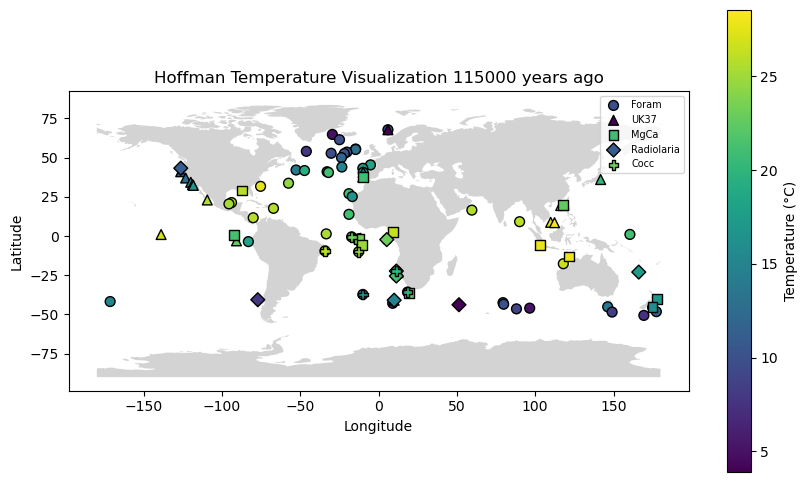

In [26]:
# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

# Load world map
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

# Define marker styles for each proxy type
proxy_marker_map = {
    "Foram": "o",  # Circle
    "UK37": "^",    # Triangle
    "MgCa": "s" ,    # Square
    "Radiolaria": "D", # Diamond
    "Cocc": "P" # Plus
}

# Change year column
year = "115000"

# Extract temperature values
temperature_values = df[year]

# Normalize temperature values for colormap
norm = plt.Normalize(vmin=temperature_values.min(), vmax=temperature_values.max())
cmap = plt.cm.viridis  # Choose a colormap

# Plot Map
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')

# Plot each proxy type with different markers and colormap
for proxy, marker in proxy_marker_map.items():
    subset = gdf[gdf['Proxy'] == proxy]
    
    # Scatter plot with color based on temperature
    scatter = ax.scatter(
        subset['Longitude'], subset['Latitude'],
        marker=marker, 
        c=subset[year],  # Color by temperature
        cmap=cmap, norm=norm, 
        edgecolor="black", s=50, label=proxy
    )

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Temperature (°C)")
# Add legend
plt.legend(title="Proxy Type")
plt.legend(prop={'size': 7})
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Hoffman Temperature Visualization {year} years ago")

plt.show()

In [ ]:
# create line plots comparing same location different proxies temperature
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(

In [63]:
years = np.arange(115000, 130100, 100).astype(str)
years

# Normalize temperature values for colormap
all_temps = df[years].values.flatten()
norm = plt.Normalize(vmin=np.nanmin(all_temps), vmax=np.nanmax(all_temps))
cmap = plt.cm.viridis

In [1]:
# Create Figure and Axis
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')

# Initialize scatter plots for each proxy type
scatter_plots = {}
for proxy, marker in proxy_marker_map.items():
    subset = gdf[gdf['Proxy'] == proxy]
    scatter_plots[proxy] = ax.scatter(
        subset['Longitude'], subset['Latitude'],
        marker=marker, cmap=cmap, norm=norm,
        edgecolor="black", s=50, label=proxy
    )

# Add colorbar
cbar = plt.colorbar(scatter_plots["Foram"], ax=ax)
cbar.set_label("Temperature (°C)")

# Add legend for proxy types
plt.legend(title="Proxy Type")

# Set labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")
title = plt.title(f"Temperature Change Over Time - Year {years[0]}")

# Update function for animation
def update(frame):
    year = years[frame]
    title.set_text(f"Temperature Change Over Time - Year {year}")

    for proxy, scatter in scatter_plots.items():
        subset = gdf[gdf['Proxy'] == proxy]
        scatter.set_array(subset[year])  # Update colors based on the new year

    return scatter_plots.values()

# Create Animation
ani = animation.FuncAnimation(fig, update, frames=len(years), interval=500, blit=False)

# Show Animation
plt.show()

NameError: name 'plt' is not defined

In [40]:
# Extract years from column names (everything after 'Proxy')
years = [col for col in df.columns if col.isdigit()]  # Extract numerical columns (years)
#years = sorted(years, key=int)  # Sort years numerically

[]